# Custom Model Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/03-movie-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/03-movie-analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/03-movie-analysis.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.



[  -z "$(lsof -ti:5432)" ] || kill -9 "$(lsof -ti:5432)"


nohup eva_server > eva.log 2>&1 &



Note: you may need to restart the kernel to use updated packages.


### Download custom user-defined function (UDF), model, and video

In [2]:
# Download UDF
!wget -nc https://www.dropbox.com/s/lharq14izp08bfz/gender.py

# Download built-in Face Detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/face_detector.py

# Download models
!wget -nc https://www.dropbox.com/s/0y291evpqdfmv2z/gender.pth

# Download videos
!wget -nc https://www.dropbox.com/s/f5447euuuis1vdy/short.mp4

File ‘gender.py’ already there; not retrieving.



File ‘face_detector.py’ already there; not retrieving.



File ‘gender.pth’ already there; not retrieving.



File ‘short.mp4’ already there; not retrieving.



### Load video for analysis

In [3]:
cursor.execute("DROP TABLE TIKTOK;")
response = cursor.fetch_all()
print(response)
cursor.execute("LOAD FILE 'short.mp4' INTO TIKTOK;")
response = cursor.fetch_all()
print(response)
cursor.execute("""SELECT id FROM TIKTOK WHERE id < 5""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                     0
0  Table Successfully dropped: TIKTOK
@query_time: 0.036311471834778786


@status: ResponseStatus.SUCCESS
@batch: 
                                                  0
0  Video successfully added at location: short.mp4
@query_time: 0.046881699934601784


@status: ResponseStatus.SUCCESS
@batch: 
    tiktok.id
0          0
1          1
2          2
3          3
4          4
@query_time: 0.2178105916827917


### Visualize Video

In [4]:
from IPython.display import Video
Video("short.mp4", embed=True)

### Create GenderCNN and FaceDetector UDFs

In [5]:
cursor.execute("""DROP UDF GenderCNN;""")
response = cursor.fetch_all()
print(response)

cursor.execute("""CREATE UDF IF NOT EXISTS 
                  GenderCNN
                  INPUT (data NDARRAY UINT8(3, 224, 224)) 
                  OUTPUT (label TEXT(10)) 
                  TYPE  Classification 
                  IMPL 'gender.py';
        """)
response = cursor.fetch_all()
print(response)

cursor.execute("""CREATE UDF IF NOT EXISTS
                  FaceDetector
                  INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
                  OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
                          scores NDARRAY FLOAT32(ANYDIM))
                  TYPE  FaceDetection
                  IMPL  'face_detector.py';
        """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                     0
0  UDF GenderCNN successfully dropped
@query_time: 0.02437913604080677


@status: ResponseStatus.SUCCESS
@batch: 
                                                    0
0  UDF GenderCNN successfully added to the database.
@query_time: 2.822970863431692
@status: ResponseStatus.SUCCESS
@batch: 
                                                  0
0  UDF FaceDetector already exists, nothing added.
@query_time: 0.018602540716528893


### Run Face Detector on video

In [6]:
cursor.execute("""SELECT id, FaceDetector(data).bboxes 
                  FROM TIKTOK WHERE id < 10""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
    tiktok.id                              facedetector.bboxes
0          0      [[ 90.70622 208.44966 281.64642 457.68872]]
1          1      [[ 91.01816 208.27583 281.0808  457.91995]]
2          2  [[ 90.358536 207.3743   283.4399   457.96234 ]]
3          3  [[ 90.694214 207.56027  284.37817  458.6282  ]]
4          4  [[ 90.684944 208.98653  282.1281   460.90894 ]]
5          5      [[ 89.47423 209.38083 283.45938 460.58548]]
6          6      [[ 88.50081 208.31546 283.29172 461.8374 ]]
7          7  [[ 89.838646 206.07619  282.93942  464.7494  ]]
8          8      [[ 90.18522 224.35588 281.29733 469.89603]]
9          9      [[ 94.34447 234.13255 279.6476  468.85303]]
@query_time: 1.2682587169110775


### Composing UDFs in a query

Detect gender of the faces detected in the video by composing a set of UDFs (GenderCNN, FaceDetector, and Crop)

In [7]:
cursor.execute("""SELECT id, bbox, GenderCNN(Crop(data, bbox)) 
                  FROM TIKTOK JOIN LATERAL  UNNEST(FaceDetector(data)) AS Face(bbox, conf)  
                  WHERE id < 10;""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
    tiktok.id                                    Face.bbox gendercnn.label
0          0  [90.70622, 208.44966, 281.64642, 457.68872]          female
1          1   [91.01816, 208.27583, 281.0808, 457.91995]          female
2          2   [90.358536, 207.3743, 283.4399, 457.96234]          female
3          3  [90.694214, 207.56027, 284.37817, 458.6282]          female
4          4  [90.684944, 208.98653, 282.1281, 460.90894]          female
5          5  [89.47423, 209.38083, 283.45938, 460.58548]          female
6          6   [88.50081, 208.31546, 283.29172, 461.8374]          female
7          7  [89.838646, 206.07619, 282.93942, 464.7494]          female
8          8  [90.18522, 224.35588, 281.29733, 469.89603]          female
9          9   [94.34447, 234.13255, 279.6476, 468.85303]          female
@query_time: 0.8337160255759954


### Visualize Output

In [8]:
import cv2
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color=(207, 248, 64)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    ret, frame = vcap.read()  # ret = 1 if the video is captured; frame is the image

    while ret:
        df = detections
        df = df[['Face.bbox', 'gendercnn.label']][df['tiktok.id'] == frame_id]
        
        if df.size:
            for bbox, label in df.values:
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                img=cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness) # object bbox
                cv2.putText(img, str(label), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, thickness-1) # object label
            video.write(img)

        # Show every fifth frame
        if frame_id % 5 == 0:
            plt.imshow(img)
            plt.show()

        if frame_id == 20:
            return

        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

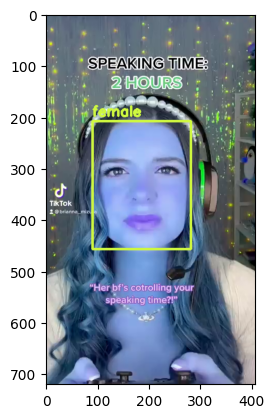

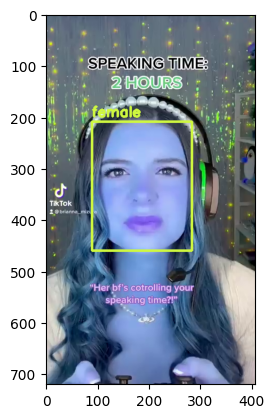

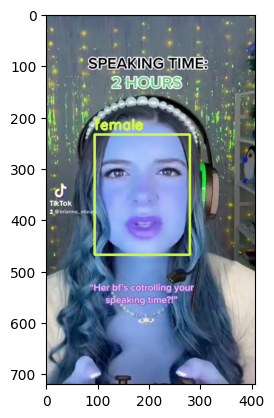

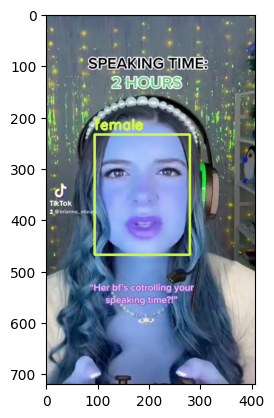

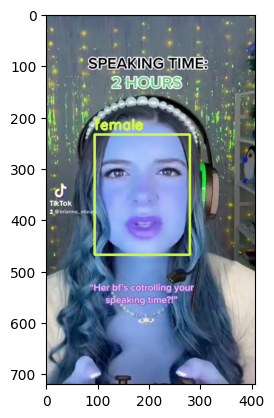

In [9]:
#!pip install ipywidgets
from ipywidgets import Video
input_path = 'short.mp4'
output_path = 'annotated_short.mp4'

dataframe = response.batch.frames
annotate_video(dataframe, input_path, output_path)